In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision import datasets
from torch.utils.data import DataLoader
import torchvision.transforms as tfs
import numpy as np
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

In [ ]:
num_epoch = 10
cuda_device = -1
batch_size = 128
device = f'cuda:{cuda_device}' if cuda_device != -1 else 'cpu'
input_d = 28*28
hidden_d_1 = 512
hidden_d_2 = 256
out_d = 10

In [ ]:
class MyLinearModel(nn.Module):
  def __init__(self, 
               input_dim: int, 
               hidden_dim1: int, 
               hidden_dim2: int,
               output_dim: int,
               ):
    super().__init__()
    
    self.linear1 = nn.Linear(input_dim, hidden_dim1)
    self.linear2 = nn.Linear(hidden_dim1, hidden_dim2)
    self.linear3 = nn.Linear(hidden_dim2, output_dim)

    self.bn1 = nn.BatchNorm1d(hidden_dim1)
    self.bn2 = nn.BatchNorm1d(hidden_dim2)

    self.activation = nn.ReLU()
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    x = self.activation(self.bn1(self.linear1(x)))
    x = self.activation(self.bn2(self.linear2(x)))
    x = self.sigmoid(self.linear3(x))

    return x

In [ ]:
data_tfs = tfs.Compose([
    tfs.ToTensor(),
    tfs.Normalize((0.5), (0.5)),
])

train_dataset = datasets.MNIST(root='data', train=True, transform=data_tfs, download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=data_tfs, download=True)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
loaders = {"train": train_dataloader, "valid": test_dataloader}

In [ ]:
model = MyLinearModel(input_d, hidden_d_1, hidden_d_2, out_d).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

In [ ]:
def learning_linear(num_epoch, loaders, model, criterion, optimizer):  
  accuracy = {"train": [], "valid": []}
  losses = []

  for epoch in range(num_epoch):
    for k, dataloader in loaders.items():
      epoch_correct = 0
      epoch_all = 0
      for x_batch, y_batch in dataloader:
        if k == 'train':
          model.train()
          optimizer.zero_grad()
          outp = model(x_batch.to(device).view(x_batch.size(0), -1))
          loss = criterion(outp, y_batch.to(device))
          loss.backward()
          optimizer.step()

        else:
          model.eval()
          with torch.no_grad():
            outp = model(x_batch.to(device).view(x_batch.size(0), -1))

        preds = outp.argmax(-1)
        correct = sum([pred == y_batch[i] for i, pred in enumerate(preds)])
        all =  len(x_batch)
        epoch_correct += correct.item()
        epoch_all += all

        losses.append(loss.detach().flatten()[0])
      if k == "train":
        print(f"Epoch: {epoch+1}")
        
      print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
      accuracy[k].append(epoch_correct/epoch_all)

  return losses

In [ ]:
losses = learning_linear(num_epoch, loaders, model, criterion, optimizer)

Epoch: 1
Loader: train. Accuracy: 0.9416166666666667
Loader: valid. Accuracy: 0.9616
Epoch: 2
Loader: train. Accuracy: 0.9750166666666666
Loader: valid. Accuracy: 0.9726
Epoch: 3
Loader: train. Accuracy: 0.9821833333333333
Loader: valid. Accuracy: 0.9761
Epoch: 4
Loader: train. Accuracy: 0.9865666666666667
Loader: valid. Accuracy: 0.978
Epoch: 5
Loader: train. Accuracy: 0.98905
Loader: valid. Accuracy: 0.9821
Epoch: 6
Loader: train. Accuracy: 0.9901333333333333
Loader: valid. Accuracy: 0.9784
Epoch: 7
Loader: train. Accuracy: 0.9916833333333334
Loader: valid. Accuracy: 0.9815
Epoch: 8
Loader: train. Accuracy: 0.9925333333333334
Loader: valid. Accuracy: 0.9826
Epoch: 9
Loader: train. Accuracy: 0.9936166666666667
Loader: valid. Accuracy: 0.9806
Epoch: 10
Loader: train. Accuracy: 0.9934
Loader: valid. Accuracy: 0.9813


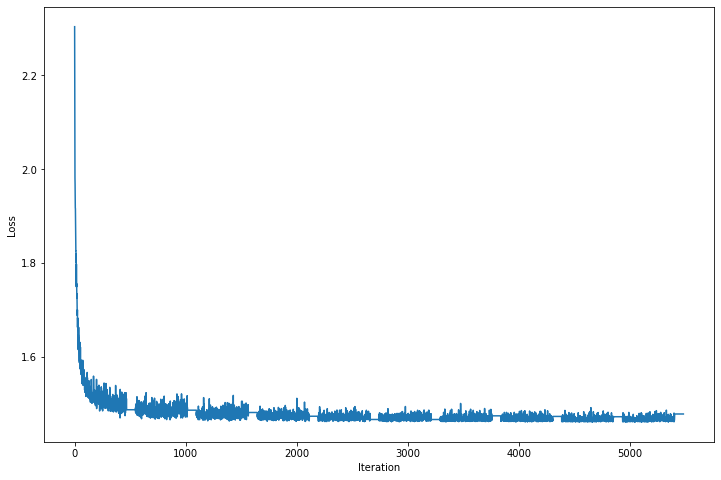

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses)), losses)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [ ]:
class ConvModel(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1, 6, 3)
    self.pool1 = nn.MaxPool2d(2, 2)
    self.conv2 = nn.Conv2d(6, 12, 3)
    self.pool2 = nn.MaxPool2d(2,2)
    self.conv3 = nn.Conv2d(12, 12, 3)

    self.linear1 = nn.Linear(1452, 512)
    self.linear2 = nn.Linear(512, 128)
    self.linear3 = nn.Linear(128, 10)
    
    self.drop = nn.Dropout(0.1)
    self.norm1 = nn.BatchNorm2d(6)
    self.norm2 = nn.BatchNorm2d(12)
    #self.norm3 = nn.BatchNorm2d(5808)

    self.activation = nn.ReLU()
    self.sigm = nn.Sigmoid()

  def forward(self, x):
    x = self.activation(self.norm1(self.conv1(x)))
    x = self.activation(self.norm2(self.conv2(x)))
    x = self.pool1(self.activation(self.conv3(x)))
    x = x.view(-1, 1452)
    x = self.activation(self.linear1(x))
    x = self.activation(self.linear2(x))
    x = self.sigm(self.linear3(x))

    return x

In [ ]:
model = ConvModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
num_epoch = 7

In [ ]:
def learning_conv(num_epoch, loaders, model, criterion, optimizer):  
  accuracy = {"train": [], "valid": []}
  losses = []

  for epoch in range(num_epoch):
    for k, dataloader in loaders.items():
      epoch_correct = 0
      epoch_all = 0
      for x_batch, y_batch in dataloader:
        if k == 'train':
          model.train()
          optimizer.zero_grad()
          outp = model(x_batch.to(device))
          loss = criterion(outp, y_batch.to(device))
          loss.backward()
          optimizer.step()

        else:
          model.eval()
          with torch.no_grad():
            outp = model(x_batch.to(device))

        preds = outp.argmax(-1)
        correct = sum([pred == y_batch[i] for i, pred in enumerate(preds)])
        all =  len(x_batch)
        epoch_correct += correct.item()
        epoch_all += all

        losses.append(loss.detach().flatten()[0])
      if k == "train":
        print(f"Epoch: {epoch+1}")
        
      print(f"Loader: {k}. Accuracy: {epoch_correct/epoch_all}")
      accuracy[k].append(epoch_correct/epoch_all)

  return losses

In [ ]:
losses_conv = learning_conv(num_epoch, loaders, model, criterion, optimizer)

Epoch: 1
Loader: train. Accuracy: 0.9238166666666666
Loader: valid. Accuracy: 0.9774
Epoch: 2
Loader: train. Accuracy: 0.98015
Loader: valid. Accuracy: 0.9858
Epoch: 3
Loader: train. Accuracy: 0.9855166666666667
Loader: valid. Accuracy: 0.984
Epoch: 4
Loader: train. Accuracy: 0.98745
Loader: valid. Accuracy: 0.988
Epoch: 5
Loader: train. Accuracy: 0.9897333333333334
Loader: valid. Accuracy: 0.9914
Epoch: 6
Loader: train. Accuracy: 0.9915833333333334
Loader: valid. Accuracy: 0.9898
Epoch: 7
Loader: train. Accuracy: 0.9920333333333333
Loader: valid. Accuracy: 0.99


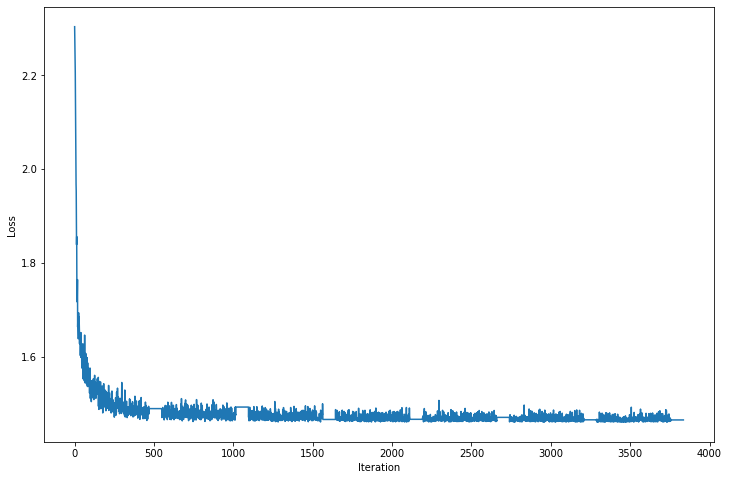

In [ ]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(losses_conv)), losses_conv)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()